     test_preparation_course  math_score  reading_score  writing_score  \
0                          1          72             72             74   
1                          0          69             90             88   
2                          1          90             95             93   
3                          1          47             57             44   
4                          1          76             78             75   
..                       ...         ...            ...            ...   
995                        0          88             99             95   
996                        1          62             55             55   
997                        0          59             71             65   
998                        0          68             78             77   
999                        1          77             86             86   

     race/ethnicity_group B  race/ethnicity_group C  race/ethnicity_group D  \
0                         1     

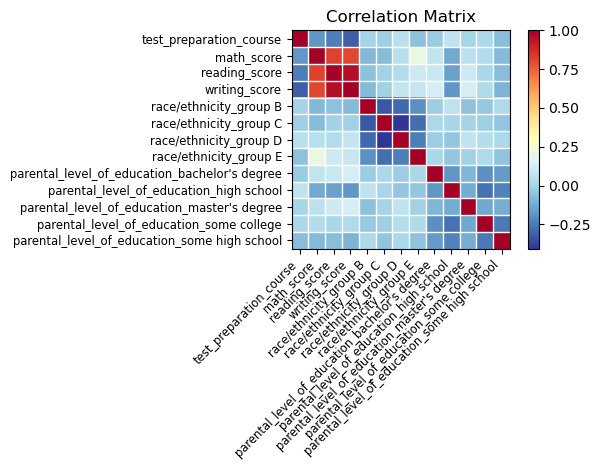

VIF: [2.803389513469437, 288.13909829915525, 280.26141925712193, 2.685990575832407, 3.908856218136494, 3.608550538237756, 2.3626383169754934, 1.5104444903045262, 1.741044697335338, 1.2797062534381816, 1.9005569013369181, 1.6557515468281838]
dropping reading_score at index 1

VIF: [2.5342204379812974, 10.093723363985703, 2.680468645453653, 3.9047168063541875, 3.5924184241092956, 2.3519906494467246, 1.5050027049684238, 1.7234813680927175, 1.2781339331954873, 1.9005447421135475, 1.629518044969929]
dropping writing_score at index 1

Final variables: ['test_preparation_course', 'race/ethnicity_group B', 'race/ethnicity_group C', 'race/ethnicity_group D', 'race/ethnicity_group E', "parental_level_of_education_bachelor's degree", 'parental_level_of_education_high school', "parental_level_of_education_master's degree", 'parental_level_of_education_some college', 'parental_level_of_education_some high school']

Train MAE: 15.851992647580722
Train RMSE: 21.445551857705777
Test MAE: 16.4478870171

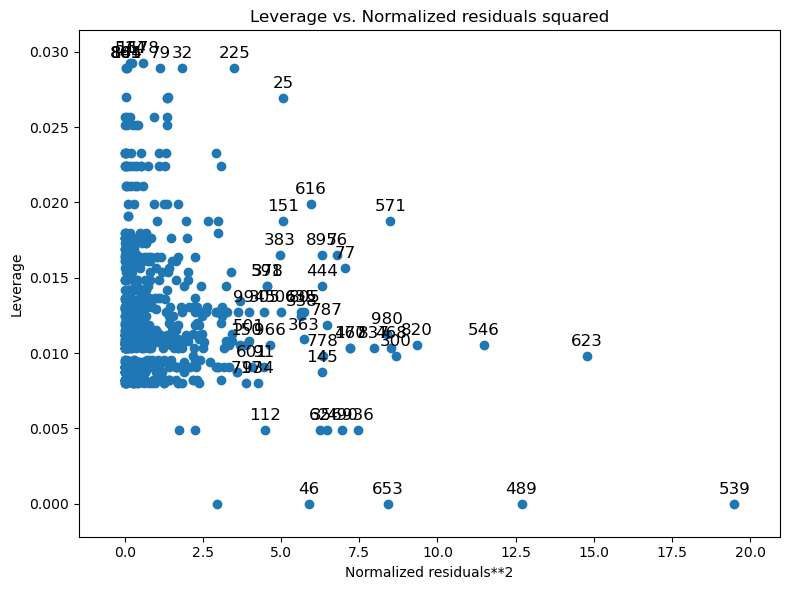

     student_resid   unadj_p   bonf(p)
539       4.550439  0.000006  0.004957


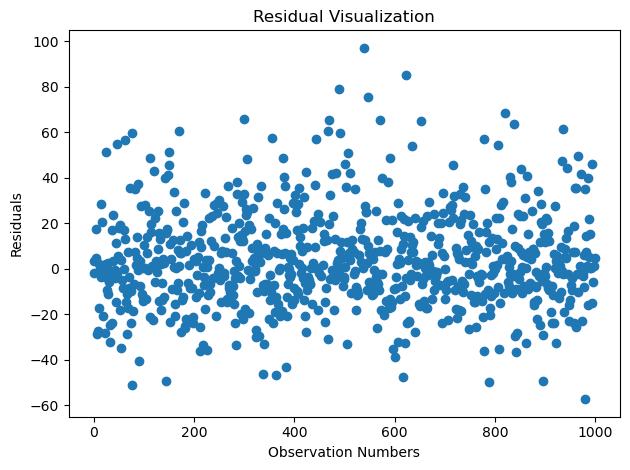

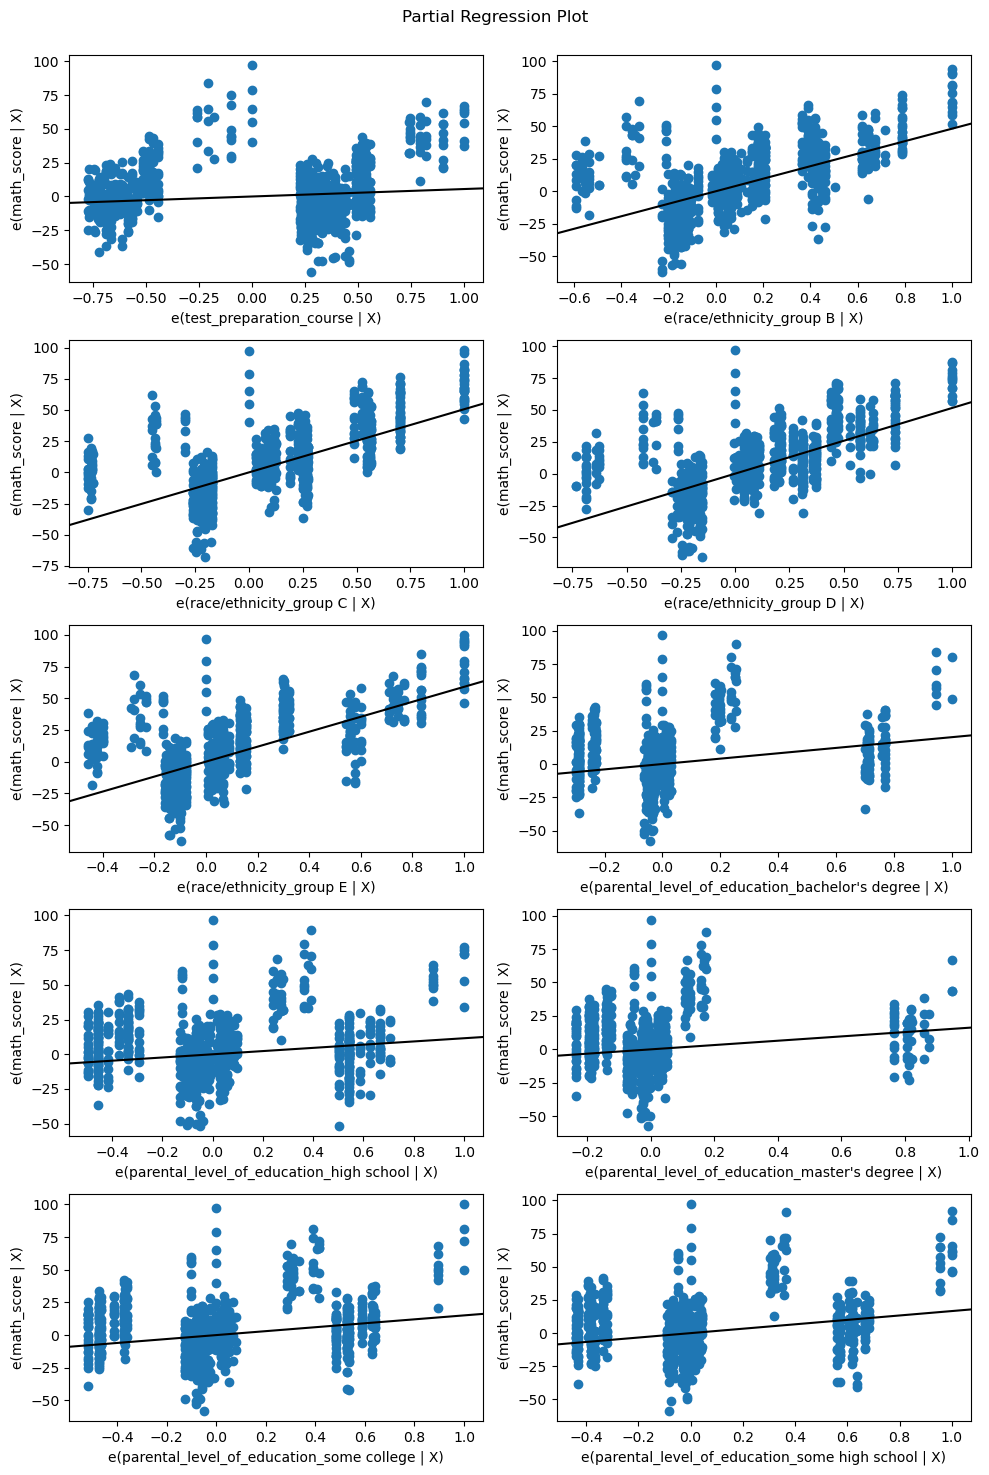

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.graphics.regressionplots import plot_leverage_resid2

df = pd.read_csv('C:/Users/Admin/Documents/StudentsPerformance.csv')
df.columns = df.columns.str.replace(' ', '_')
#Dropping Unnecessary Columns
df.drop(columns=['gender', 'lunch'], inplace=True)

#Handling categorical Columns & Multiclasss Columns
df = pd.get_dummies(df, columns=['race/ethnicity', 'parental_level_of_education'], drop_first=True, dtype=int)
lb = LabelBinarizer()
df.test_preparation_course = lb.fit_transform(df.test_preparation_course)
print(df)

#Visualizing Correlation
corr = df.corr()
sm.graphics.plot_corr(corr, xnames=list(corr))
plt.show()
#We saw stong negative correlation between race/ethnicity_group C & D

independent_variables = ['test_preparation_course', 'reading_score', 'writing_score', 'race/ethnicity_group B', 
                        'race/ethnicity_group C', 'race/ethnicity_group D', 
                         'race/ethnicity_group E',"parental_level_of_education_bachelor's degree", 
                         'parental_level_of_education_high school',
                        "parental_level_of_education_master's degree", 'parental_level_of_education_some college',
                        'parental_level_of_education_some high school']
x = df[independent_variables]
y = df['math_score']
#print(x.shape[0])
#print(x.shape[1])
thresh = 10
while True:
    x = df[independent_variables]
    vif = [variance_inflation_factor(x, ix) for ix in range(x.shape[1])]
    maxloc = vif.index(max(vif))
    if max(vif) > 10:
        print(f'VIF: {vif}')
        print(f'dropping {independent_variables[maxloc]} at index {maxloc}\n')
        del independent_variables[maxloc]
    else:
        break;

print(f'Final variables: {independent_variables}\n')

#Train and Test Model
x = df[independent_variables]
y = df['math_score']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.80, random_state=1)

model = sm.OLS(y_train, x_train).fit()

print(f'Train MAE: {metrics.mean_absolute_error(y_train, model.predict(x_train))}')
print(f'Train RMSE: {np.sqrt(metrics.mean_squared_error(y_train, model.predict(x_train)))}')
print(f'Test MAE: {metrics.mean_absolute_error(y_test, model.predict(x_test))}')
print(f'test RMSE: {np.sqrt(metrics.mean_squared_error(y_test, model.predict(x_test)))}')

print(model.summary())

#Regression Diagnosis
fig, ax=plt.subplots(figsize=(8, 6))
plot_leverage_resid2(model, ax=ax)
plt.tight_layout()
plt.show()

#Bonferroni outlier test
test = model.outlier_test()
print(test[test['bonf(p)'] < 0.05])

plt.plot(model.resid, 'o')
plt.title('Residual Visualization')
plt.xlabel('Observation Numbers')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

fig=plt.figure(figsize=(10, 15))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()